# LeNet

here I rebuild the LeNet famous architecture from Yan LeCun, th efirst CNN network to outperform over cifar dataset

In [42]:
import torch 
from torch import nn, optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [43]:
def init_cnn(module):
  if type(module) == nn.Linear or type(module) == nn.Conv2d:
    nn.init.xavier_uniform_(module.weight)

In [59]:
class LeNet(nn.Module):
  def __init__(self, num_classes=10):
    super().__init__()
    self.net = nn.Sequential(
        nn.LazyConv2d(6, kernel_size=5, padding=2),
        nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
        nn.LazyConv2d(16, kernel_size=5),
        nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.LazyLinear(120), nn.Sigmoid(),
        nn.LazyLinear(84), nn.Sigmoid(),
        nn.LazyLinear(num_classes)
    )
  
  def forward(self, X):
    return self.net(X)

  def layer_summary(self, X_shape):
    X = torch.randn(*X_shape).to(device)
    print('X', 'output shape:\t', X.shape)
    for layer in self.net:
      X = layer(X)
      print(layer.__class__.__name__, 'output shape:\t', X.shape)

In [60]:
def accuracy(X, y):
  out = model(X.to(device)).argmax(axis=1).to('cpu')
  compare = (out == y).type(torch.float32)
  return compare.mean()

In [61]:
#general purpose dataset dataloader
class LeNet_Dataset(Dataset):
  def __init__(self, file):
    super.__init__()
    self.X = None
    self.y = None

  def __len__(self):
    raise  NotImplemented

  def __getitem__(self, idx):
    return {"X": self.X[idx], 'y': self.y[idx]}
    
#LeNet_data = LeNet_Dataset() 
#LeNet_loader = DataLoader(LeNet_data ,batch_size=8, shuffle=True, num_workers=4, pin_memory=True)


In [62]:
def get_model():

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = LeNet().to(device)
  model.layer_summary((1, 1, 28, 28))
  return model, optim.SGD(model.parameters(), lr=0.1), nn.CrossEntropyLoss()

def data_preparation(batch = 128):

  transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

  data_train = datasets.FashionMNIST('~/.pytorch/F_MNIST_data', train=True, transform=transform, download = True);
  data_test = datasets.FashionMNIST('~/.pytorch/F_MNIST_data', train=False, transform=transform, download = True);

  split1 = int(np.floor(0.8*len(data_train)))
  split2 = int(np.floor(0.2*len(data_train)))
  train = data_train
  test = data_test

  bs = batch
  train_dl = DataLoader(train ,batch_size=bs, shuffle=False, sampler=range(split1), num_workers=4, pin_memory=True)
  val_dl = DataLoader(train ,batch_size=bs, shuffle=False, sampler=range(split2), num_workers=4, pin_memory=True)
  test_dl = DataLoader(test ,batch_size=bs, shuffle=True, num_workers=4, pin_memory=True)

  print(len(train), len(test), len(train_dl) ,len(val_dl), len(test_dl))

  return train_dl, val_dl, test_dl

train_dl, val_dl, test_dl = data_preparation()


60000 10000 375 94 79


In [64]:
model, opt, loss_f = get_model()

#here we chose the weights initialization we have to pass an example imput to comput dimentions because we are using lazy layers
model.apply(init_cnn);

X output shape:	 torch.Size([1, 1, 28, 28])
Conv2d output shape:	 torch.Size([1, 6, 28, 28])
Sigmoid output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
Sigmoid output shape:	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


In [66]:
epochs = 15
train_loss = []
val_loss = []
acc = []
t_loss, v_loss, a = [], [], []

#train
for epoch in range(epochs):
  model.train()
  for X, y in train_dl:

    X = X.to(device)
    y = y.to(device)
    opt.zero_grad()
    out = model(X)
    
    loss = loss_f(out, y)
    
    loss.backward()
    opt.step()
    #print(out,train_loss)
    t_loss.append(loss.item())    
  train_loss.append(np.mean(t_loss))
  
  model.eval()
  for X, y in val_dl:
    with torch.no_grad():
      out = model(X.to(device))
      v_loss.append(loss_f(out, y.to(device)).item())
  val_loss.append(np.mean(v_loss))

  for X, y in test_dl:
    with torch.no_grad():
      a.append(accuracy(X, y))
  acc.append(np.mean(a))
    
  print("Epoch: {}, loss = {}, v_loss = {}, accuracy = {}".format(epoch, train_loss[-1], val_loss[-1], acc[-1]))

Epoch: 0, loss = 2.307462759017944, v_loss = 2.304942011833191, accuracy = 0.0995846539735794
Epoch: 1, loss = 2.2985608088175455, v_loss = 2.2649469324882996, accuracy = 0.17637459933757782
Epoch: 2, loss = 2.120459870974223, v_loss = 1.9535786742014243, accuracy = 0.29341375827789307
Epoch: 3, loss = 1.884783267656962, v_loss = 1.729645513156627, accuracy = 0.37097012996673584
Epoch: 4, loss = 1.706604715601603, v_loss = 1.5689426895151748, accuracy = 0.42838212847709656
Epoch: 5, loss = 1.569400276237064, v_loss = 1.4468054082376738, accuracy = 0.47217828035354614
Epoch: 6, loss = 1.460725324017661, v_loss = 1.3504816808236768, accuracy = 0.5061454772949219
Epoch: 7, loss = 1.3722259431878725, v_loss = 1.2718935745193602, accuracy = 0.5335987210273743
Epoch: 8, loss = 1.2987195489318282, v_loss = 1.2067235084712928, accuracy = 0.5563796758651733
Epoch: 9, loss = 1.236995688867569, v_loss = 1.1520274728536606, accuracy = 0.5751582384109497
Epoch: 10, loss = 1.1845588351885479, v_loss

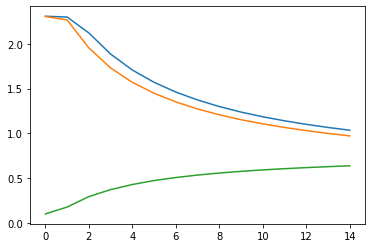

In [67]:
import matplotlib.pyplot as plt
plt.plot(train_loss)
plt.plot(val_loss)
plt.plot(acc)

In [41]:
bcX, bcy = next(iter(test_dl))

out = model(bcX.to(device))
loss = loss_f(out.to('cpu'), bcy)
out.max(dim=1)[1], bcy, loss.item()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(tensor([9, 5, 8, 7, 4, 8, 4, 3, 4, 9, 3, 2, 6, 5, 5, 8, 6, 8, 3, 3, 3, 7, 8, 3,
         1, 5, 4, 3, 7, 3, 2, 9, 5, 2, 7, 0, 0, 5, 2, 7, 0, 9, 0, 4, 8, 7, 3, 2,
         1, 5, 8, 4, 5, 2, 1, 2, 3, 4, 0, 4, 9, 5, 1, 0, 3, 1, 3, 5, 5, 1, 7, 5,
         7, 2, 9, 5, 8, 2, 4, 0, 7, 4, 0, 2, 9, 3, 3, 1, 8, 7, 7, 9, 1, 9, 7, 0,
         4, 2, 0, 7, 4, 7, 9, 9, 5, 8, 8, 3, 6, 9, 4, 0, 4, 3, 3, 3, 0, 3, 4, 5,
         9, 5, 7, 8, 1, 1, 9, 8], device='cuda:0'),
 tensor([7, 5, 8, 7, 6, 8, 2, 3, 3, 9, 0, 4, 6, 5, 5, 8, 6, 8, 0, 0, 3, 7, 8, 3,
         1, 5, 4, 3, 5, 3, 2, 9, 5, 6, 7, 2, 6, 7, 6, 7, 0, 9, 0, 4, 8, 7, 2, 6,
         1, 5, 8, 4, 5, 2, 1, 6, 3, 4, 0, 4, 9, 5, 1, 0, 3, 1, 2, 5, 5, 1, 7, 5,
         7, 2, 9, 5, 8, 2, 6, 6, 7, 2, 0, 2, 9, 3, 3, 1, 8, 7, 7, 9, 1, 9, 7, 6,
         4, 2, 0, 7, 6, 5, 9, 9, 5, 8, 8, 3, 4, 9, 1, 6, 4, 3, 1, 1, 3, 3, 4, 5,
         9, 5, 7, 8, 1, 1, 9, 8]),
 0.555963397026062)